## 第十二週：主題模型（中文）
**Autor**: 張芳瑜 <br>
**Date created**: 2021/09/27 <br>
**Last modified**: 2021/10/07

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標。<br>
<br>
這次課程分為四個部分：1.介紹使用到的套件 2.將資料進行前處理 3.建立LDA模型 4.視覺化主題模型

In [31]:
# 移除警告語
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## 大綱
1. 套件說明
1. 資料前處理
    + 2.1 資料描述
    + 2.2 Jieba中文斷詞、匯入字典
    + 2.3 去除停用字
1. LDA 主題模型
    + 3.1 訓練LDA模型
    + 3.2 查看 LDA 主題代表字
    + 3.3 查看 LDA 模型指標
    + 3.4 透過指標找出最佳主題數
1. 視覺化呈現
    + 4.1 產生 LDAvis 結果
    + 4.2 查看 Document 主題時間上分佈

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ pandas:提供高效能、簡易使用的資料格式與資料處理的函數。
+ jieba:中文斷詞套件
+ re:正規化表達式套件
+ matplotlib:繪圖工具
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [52]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models

In [6]:
# 設定圖的字體大小
font = {'size':14}
matplotlib.rc('font', **font)

## 2. 資料前處理
根據文字處理基本流程，我們需要將我們的資料進行資料前處理。
+ 資料收集：通常我們使用網路爬蟲技術來取得資料（網路爬蟲非本課程之目的），因此在此範例中，我們使用中山管院文字分析平台，來收集文本資料。
+ 資料清理：將文本內容轉為正規語句，例如：統一標點符號、去除特定標籤等等。
+ 斷詞、斷句：使用工具區分文章中的句子、詞彙，以便於進行分析。
+ 去除停用字：將與分析無關的詞彙去除，例如：語助詞、連接詞等等，來避免影響後續分析結果。

**2.1 資料描述**
+ 來源：聯合新聞網、蘋果新聞網、東森新聞網（中山管院文字分析平台）
+ 時間：2020/10/01 到 2021/05/09，隨機選1000篇新聞。
+ 搜尋關鍵字：疫苗

In [22]:
# 匯入資料
data = pd.read_csv('./raw_data/news_articleMetaData.csv', encoding='UTF-8')
metadata = data.sample(n=1000, random_state=2021).reset_index(drop=True)

**查看「疫苗」的相關報導在時間上的數量走勢** <br>
+ 將資料中「artDate」(報導日期)groupby起來，並計算數量。
+ 日期資料轉換為日期格式，之後圖示會幫助閱讀。

In [23]:
# groupby artDate 轉為新的DataFrame
day_count = pd.DataFrame({
    'date': metadata.groupby('artDate').size().index,
    'count': metadata.groupby('artDate').size().values
})
day_count = day_count.sort_values(by='date') # 排序
day_count.date = pd.to_datetime(day_count['date']) # 將裡面資料轉為日期格式

+ 觀察折線圖，可以發現疫苗的相關報導在2月過後數量有增加的趨勢。
+ 在三月中旬數量達到高峰，四月後逐漸減少

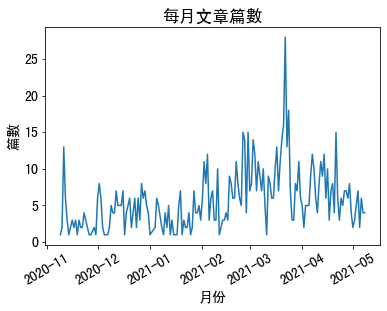

In [24]:
plt.plot(day_count['date'], day_count['count'])
plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30) # 旋轉x刻度避免重疊
plt.show()

**2.2 Jieba中文斷詞、匯入字典**

斷詞引擎設定：使用 Jieba 當作斷詞系統。<br>

Jieba 原先內建為簡體字字典，因此我們匯入繁體字典，斷詞結果會比較好。<br>
另外，在一些特殊主題裡，會有獨特的專有名詞，因此我們需要加入這些字詞進去。<br>
兩種方式：1.匯入檔案 2.參數形式手動加入

以下用匯入檔案的方式：

In [135]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
jieba.set_dictionary('./dict/dict.txt') 

# 自定義辭典
print("--> 匯入自定義字典，這裡匯入疫苗的名稱")
jieba.load_userdict('./dict/user_dict.txt')


Building prefix dict from /Users/changfangyu/Desktop/NSYSU/碩班/110 社群媒體/code/SMA_2021F/week12_topic_model/dict/dict.txt ...


--> 匯入自定義字典，這裡匯入疫苗的名稱


Dumping model to file cache /var/folders/yw/v6fz89fx5pd827bs1070ywr00000gn/T/jieba.uc85171de1e540c6b3e7b255b0701718a.cache
Loading model cost 0.477 seconds.
Prefix dict has been built successfully.


拿取資料裡 url(連結)、sentence(文章)，並將文章內容進行斷詞

In [114]:
# 資料進行斷詞，為list的格式
data = metadata[['artUrl','sentence']]
token_df = data.assign(wordlist = data['sentence'].apply(jieba.lcut))

print("資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)")
token_df.head(3)

資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)


,artUrl,sentence,wordlist
0,https://tw.appledaily.com/international/202103...,美國總統拜登11日在簽署1.9兆美元紓困後發表上任後首次的黃金時段演說，他表示會下令各州在5...,"[美國, 總統, 拜登, 11, 日, 在, 簽署, 1.9, 兆, 美元, 紓困, 後, ..."
1,https://udn.com/news/story/120940/5343188,國內3月22日開打AZ疫苗後，傳出北部某醫學中心一名40多歲護理師，接種AZ疫苗後出現急性過...,"[國內, 3, 月, 22, 日, 開打, AZ, 疫苗, 後, ，, 傳出, 北部, 某,..."
2,https://udn.com/news/story/120944/5055649,俄羅斯新聞社（RIA）今天引述聯邦消費者權益保護暨福利監督署的說法報導，俄羅斯計劃從今天起對...,"[俄羅斯, 新聞社, （, RIA, ）, 今天, 引述, 聯邦, 消費者, 權益, 保護,..."


**2.3 去除停用字**

為了提高準確度，我們會將停用字移除，例如：空格、標點符號、語助詞...等。<br>
兩種方式： 1.匯入檔案 2.參數形式手動加入

以下使用匯入檔案的方式：

In [115]:
stopwords = []

#匯入檔案
with open(f'./dict/stopwords.txt','r') as f:
    stopwords = f.read().splitlines() #移除換行符號\n

print("stropwords儲存為list形式，前幾個為：")
stopwords[:15]

stropwords儲存為list形式，前幾個為：


['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”']

除了移除停用字，也可以設定其他條件。
+ 字的長度要大於一
+ 只選沒有在停用字點裡的字
+ 用正規表達式移除，舉例：\d 移除數字

In [116]:
# 移除停用字的 function
def remove_stop(listt):
    result = [re.sub(r'\d|-', '', word) for word in listt]
    result = [word for word in result if len(word)>1] 
    result = list(filter(lambda x : x not in stopwords, result)) 
    return result

In [117]:
# list 刪掉 stopwords
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove_stop))
print("remove_stopwords 為 wordlist 移除停用字後的結果：")
token_df.head(3)

remove_stopwords 為 wordlist 移除停用字後的結果：


,artUrl,sentence,wordlist,remove_stopwords
0,https://tw.appledaily.com/international/202103...,美國總統拜登11日在簽署1.9兆美元紓困後發表上任後首次的黃金時段演說，他表示會下令各州在5...,"[美國, 總統, 拜登, 11, 日, 在, 簽署, 1.9, 兆, 美元, 紓困, 後, ...","[美國, 總統, 拜登, 簽署, 美元, 紓困, 發表, 上任, 首次, 黃金, 時段, 演..."
1,https://udn.com/news/story/120940/5343188,國內3月22日開打AZ疫苗後，傳出北部某醫學中心一名40多歲護理師，接種AZ疫苗後出現急性過...,"[國內, 3, 月, 22, 日, 開打, AZ, 疫苗, 後, ，, 傳出, 北部, 某,...","[國內, 開打, AZ, 疫苗, 傳出, 北部, 醫學, 中心, 一名, 多歲, 護理師, ..."
2,https://udn.com/news/story/120944/5055649,俄羅斯新聞社（RIA）今天引述聯邦消費者權益保護暨福利監督署的說法報導，俄羅斯計劃從今天起對...,"[俄羅斯, 新聞社, （, RIA, ）, 今天, 引述, 聯邦, 消費者, 權益, 保護,...","[俄羅斯, 新聞社, RIA, 今天, 引述, 聯邦, 消費者, 權益, 保護, 福利, 監..."


## 3. LDA 主題模型

Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文黨集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

**3.1 訓練 LDA 模型**

將文章斷詞結果儲存為 list 資料形態，一篇文章為一個 list ，其中 element 為詞彙。

In [118]:
token_data = token_df['remove_stopwords'].tolist()

In [119]:
for i in range(0,3):
    print("第 " + str(i+1) + " 篇文章前10個字：")
    for j in range(0,10):
        print(token_data[i][j], end=' ')
    print('\n')

第 1 篇文章前10個字：
美國 總統 拜登 簽署 美元 紓困 發表 上任 首次 黃金 

第 2 篇文章前10個字：
國內 開打 AZ 疫苗 傳出 北部 醫學 中心 一名 多歲 

第 3 篇文章前10個字：
俄羅斯 新聞社 RIA 今天 引述 聯邦 消費者 權益 保護 福利 



id2word 將斷詞結果生成字典，裡頭為資料集裡出現的字。

In [170]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(19236 unique tokens: ['COVID', '一再', '一同', '一次', '一般人']...)


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[0]:[(0, 1), (1, 1), (2, 3), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表'COVID-'出現一次、一再出現一次、一同出現三次...以此類推

In [171]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 1), (5, 1), (6, 3), (7, 2), (8, 1), (9, 1)]


參數說明：
+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [157]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=1005, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)

**3.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
(0, '0.017*"疫苗" + 0.007*"委員會" + 0.006*"採購" ... )<br>
-> 第一個主題的詞彙分佈，0.017:疫苗、0.007:委員會、0.006:採購...（全部詞彙加起來會等於一）

In [167]:
# 每個主題重要的前十個關鍵字
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.017*"疫苗" + 0.007*"委員會" + 0.006*"採購" + 0.005*"接種" + 0.005*"調閱"')
(1, '0.058*"疫苗" + 0.027*"接種" + 0.012*"施打" + 0.009*"表示" + 0.009*"AZ"')
(2, '0.059*"疫苗" + 0.011*"接種" + 0.010*"病毒" + 0.009*"中國" + 0.008*"表示"')
(3, '0.043*"疫苗" + 0.011*"疫情" + 0.008*"接種" + 0.008*"試驗" + 0.008*"表示"')


我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：委員會討論「疫苗採購調閱專案小組」相關報導
+ 主題二：AZ 疫苗施打
+ 主題三：中國疫苗接種
+ 主題四：疫苗接種臨床試驗相關報導

**3.3 查看 LDA 模型指標**
+ **Pairwise Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度。<br>
數字要越小越好，通常圖形為下降後上升再持續下降，但我們需要選擇第二次下降附近的主題數，因為第二次下降為 overfitting 的結果。

In [174]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  0.020259414917299864


In [176]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -7.768912086191343


**3.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數，這裡以 perplexity 為指標來做判斷，可以發現主題數在 4 之後 overfitting，因此我們選擇主題數 4 來做分析。

再次強調：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試著做參數上的調整，或者是主題數的調整，進而比較出較佳的模型結果。

In [168]:
topic_num_list = [2,3,4,5,6,7,8,9,10]
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1005,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)

    result.append({"topic_num": topic_num, "perplexity": tmp_perplexity})
#3分鐘跑完

,topic_num,perplexity
0,2,-7.776124
1,3,-7.755924
2,4,-7.770530
3,5,-7.778284
4,6,-7.792756
5,7,-7.796345
6,8,-7.807075
7,9,-7.822203
8,10,-7.823767


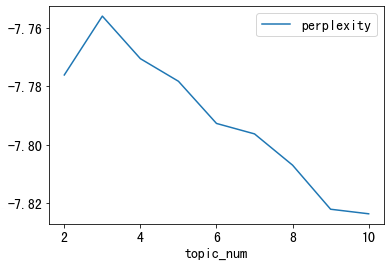

In [169]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

## 4. 視覺化呈現

**4.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

In [166]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis.html')

/Users/changfangyu/opt/anaconda3/envs/fanny_nltk/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


**4.2 查看 Document 主題時間上分佈**

使用模型分析我們的資料，取得每條新聞的主題分佈，選最大的設為此文章的主題。<br>
再根據時間來做分析，了解不同的時間點討論的主題大多為什麽，以比例的方式呈現。

In [178]:
# 取得每條新聞的主題分佈
topics_doc = ldamodel.get_document_topics(corpus)  

# 將結果列成list
doc_list = []

# topics_doc[i] 為第一個文章
for i in range(0,len(topics_doc)):

    # 都先假定第一個主題為最大的
    max_freq = topics_doc[i][0][1]
    max_topic = topics_doc[i][0][0]

    # 後面假如有比較大的就取代
    for j in topics_doc[i]:
        if(j[1] > max_freq):
            max_freq = j[1]
            max_topic = j[0]

    doc_list.append(max_topic)

In [179]:
# 將結果放進 DataFrame裏
metadata['topic'] = doc_list

In [180]:
# 將 artDate 轉換為 Python 日期時間
metadata.artDate = pd.to_datetime(metadata['artDate'])

In [183]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':metadata.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
# date_topic.artDate.dt.to_period('M')：把日期按月份形式表示
date_topic = date_topic.groupby([date_topic.artDate.dt.to_period('M'),'topic']).sum().reset_index()


In [185]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2', 'topic3']
# 前面日期變period形式要把他變回timestamp形式 --> to_timestamp：以便於畫圖
date_df = date_df.set_index('artDate').to_timestamp()
date_df

,topic0,topic1,topic2,topic3
artDate,,,,
2020-11-01,2.0,6.0,35.0,13.0
2020-12-01,1.0,36.0,74.0,21.0
2021-01-01,1.0,9.0,41.0,33.0
2021-02-01,1.0,72.0,94.0,25.0
2021-03-01,20.0,183.0,73.0,19.0
2021-04-01,8.0,136.0,44.0,20.0
2021-05-01,0.0,14.0,11.0,8.0


可以看到在不同時間點，特定主題談論篇幅的多寡

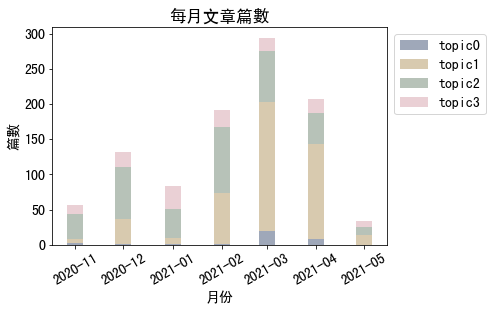

In [220]:
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8", "#EAD0D5"]
column = ['topic0', 'topic1', 'topic2', 'topic3']
temp_bottom = 0

for i in range(0,4):
    if(i>0):
        temp_bottom = temp_bottom + date_df[column[i-1]]
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=10)
    else: # 主題一 bottom 為 0
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], label=column[i] , width=10)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

我們也可以將它轉換為比例來看

In [221]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2 + ratio_df.topic3

for i in range(0,4):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

,topic0,topic1,topic2,topic3,sum
artDate,,,,,
2020-11-01,0.035714,0.107143,0.625000,0.232143,56.0
2020-12-01,0.007576,0.272727,0.560606,0.159091,132.0
2021-01-01,0.011905,0.107143,0.488095,0.392857,84.0
2021-02-01,0.005208,0.375000,0.489583,0.130208,192.0
2021-03-01,0.067797,0.620339,0.247458,0.064407,295.0
2021-04-01,0.038462,0.653846,0.211538,0.096154,208.0
2021-05-01,0.000000,0.424242,0.333333,0.242424,33.0


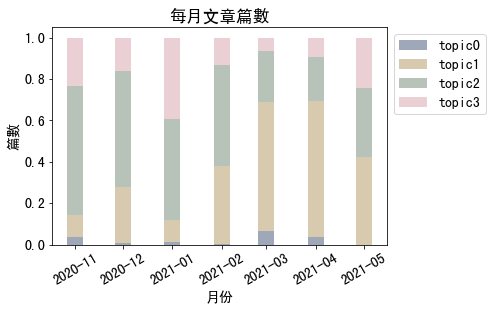

In [222]:
temp_bottom = 0

for i in range(0,4):
    if(i>0):
        temp_bottom = temp_bottom + ratio_df[column[i-1]]
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i], width=10)
    else: # 主題一 bottom 為 0
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], label=column[i], width=10)

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

可以根據上面的圖表，搭配時事推估，例如：
+ topic2 前面的比例較高，後面漸漸變少，推估應該是那時候在爭少是否引進中國新冠疫苗
+ topic0 跟其他主題相較起來篇幅最少，推測當時相關新聞應該為少數
+ topic1 則是在後期篇幅變多，推測應該是 AZ疫苗開始施打而開始有大篇幅的報導
+ topic3 在一月的時候有大篇幅的增加，推估可能是因為公費疫苗擴大提供全民接種

隨機看一下不同主題大概都在談論什麼

In [213]:
## 主題一
metadata[metadata['topic'] == 0].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
706,打完AZ疫苗第一晚不只背痠 陳時中自曝：還有小發燒,2021-03-23,19:18:00,https://udn.com/news/story/120940/5338495,我國AZ疫苗昨天正式開打，衛福部長陳時中昨陪同行政院長蘇貞昌赴台大醫院打AZ疫苗，兩人一起帶...,0
446,不甩蘇揆籲「勿害台灣買不到疫苗」 陳玉珍：調閱小組才能監督政府採購,2021-03-21,20:43:49,https://tw.appledaily.com/politics/20210321/DP...,朝野立委上週就是否在立法院衛環委員會設「疫苗採購調閱小組」交火，衛環委員會明（22日）將確認...,0
288,籲快成立疫苗小組 費鴻泰：否則國營事業預算焦土杯葛,2021-03-25,17:31:00,https://udn.com/news/story/120940/5343752,質疑新冠肺炎疫苗採購黑箱，國民黨團在衛環委員會突襲提案成立疫苗採購調閱小組，民進黨團雖妥協，...,0
673,【武漢肺炎】復星醫藥交疫苗報告稱「沒安全問題」 香港將復打BNT疫苗,2021-04-01,17:37:05,https://tw.appledaily.com/international/202104...,由上海復星醫藥供應的「復必泰」BioNTech疫苗在上周三（3月24日）發現包裝有瑕疵而暫停...,0
4,國會混戰！堅持組疫苗調閱小組 林為洲：國民黨好想贏,2021-03-24,10:43:00,https://udn.com/news/story/6656/5339602,立法院衛環委員會上周表決通過成立「疫苗採購調閱小組」，本周一民進黨立委陳瑩擔任召委表決刪除該...,0


In [215]:
## 主題二
metadata[metadata['topic'] == 1].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
273,AZ疫苗下周一開打 我專家點名蘇貞昌、陳時中帶頭接種,2021-03-19,19:37:00,https://udn.com/news/story/120940/5330303,指揮中心指揮官陳時中今晚宣布，AZ新冠疫苗於今年3月22日開打，也就是下周一為我國新冠肺炎施...,1
530,台灣何時施打新冠疫苗？陳時中：不會早於明年3月,2020-12-08,18:12:00,https://udn.com/news/story/120940/5076446,英國已啟動新冠肺炎疫苗大規模施打計畫，各界也關注我國何時能施打新冠肺炎疫苗。衛福部長陳時中今...,1
977,【武漢肺炎】去霉運？AZ疫苗在歐洲波折不斷 改名Vaxzevria,2021-04-06,17:19:40,https://tw.appledaily.com/international/202104...,歐洲多國接種阿斯特捷利康的武漢肺炎疫苗（AZ疫苗）發生血栓不良事件，歐盟藥品管理局（EMA）...,1
384,英國搶先施打疫苗 比利時總理提醒是歐洲製造｜東森新聞,2020-12-09,00:00:00,https://news.ebc.net.tw/news/article/239885,英國今天領先全球開打2019冠狀病毒疾病疫苗，首相強生發文感謝，不過因英國即將結束脫離歐盟的...,1
168,東奧舉行在即籲選手優先施打疫苗 陳時中：盡量配合,2021-02-25,15:06:00,https://udn.com/news/story/120940/5276633,受新冠肺炎疫情影響，原定去年七月於日本東京舉行的奧運被迫延期。如今，新冠疫苗陸續出爐，國際奧...,1


In [216]:
## 主題三
metadata[metadata['topic'] == 2].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
407,籲陸不阻他國售台疫苗 謝長廷：台灣自能感受善意,2021-02-15,19:07:00,https://udn.com/news/story/6656/5252034,新冠疫情嚴峻，各國爭相訂購疫苗，前總統馬英九、媒體人趙少康昨天說，政府應思考是否採用「中國疫...,2
808,直播／莫德納再研發新疫苗 台灣拿得到？ 陳時中14：00說明,2021-02-25,10:05:00,https://udn.com/news/story/120940/5275612,指揮中心今上午公佈，指揮官陳時中將於下午2時舉行記者會。美國莫德納藥廠24日宣布，設計了幫助...,2
932,4大藥廠有信心 自家新冠疫苗能對抗新變種病毒,2020-12-23,11:56:00,https://udn.com/news/story/120944/5115060,德國BioNTech等至少4家藥廠都預期自家2019冠狀病毒疾病（COVID-19）疫苗能有...,2
857,新毒株將讓疫苗失效？專家曝「現有疫苗仍有效」關鍵原因,2020-12-21,17:58:00,https://udn.com/news/story/120944/5110171,美國華盛頓大學健康計量評估研究中心所助理教授古波塔（Vin Gupta）21日表示，現有的新...,2
55,【武漢肺炎】研究：疫苗接種計畫讓英國3月確診率大幅下降,2021-04-08,21:13:55,https://tw.appledaily.com/international/202104...,根據英國今天（8日）發表的一項調查顯示，英格蘭順利展開疫苗接種計畫已開始出現正面的影響，3月...,2


In [217]:
## 主題四
metadata[metadata['topic'] == 3].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
68,韓國公布新冠肺炎疫苗接種計畫 外國人也可施打,2021-01-28,16:53:00,https://udn.com/news/story/120944/5212962,韓國政府今天公布2019冠狀病毒疾病（COVID-19，新冠肺炎）疫苗接種時程，當局表示，除...,3
61,印度疫情失控 美：2022生產10億劑疫苗計畫不變,2021-04-27,12:27:00,https://udn.com/news/story/120944/5416531,美國與3個印太夥伴協議於2022年底前在印度生產多達10億劑COVID-19疫苗，以供應其他...,3
779,英國提大膽建議 拉長疫苗接種間隔拚普及施打,2020-12-31,16:29:00,https://udn.com/news/story/120944/5137021,英國批准牛津新型冠狀病毒疫苗緊急使用，還建議兩劑間隔可在4到12週之間。然而間隔12週的方式...,3
913,接種第二劑輝瑞疫苗好興奮 60歲男4天後離奇死亡｜東森新聞,2021-01-28,00:00:00,https://news.ebc.net.tw/news/article/247426,美國加州一名男子近日接種第二劑輝瑞藥廠（Pfizer）和德國BioNTech研發的疫苗，施打...,3
635,佛奇：美國未成年人有望秋後開始打疫苗,2021-03-01,12:33:00,https://udn.com/news/story/120944/5285286,美國國家過敏與傳染病研究院（NIAID）主任佛奇今天表示，美國可望秋天結束前開始替高中左右年...,3
